In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# anthony
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive'
%ls
%cd MyDrive
# %cd drive
# %cd MyDrive
%cd Lab4

# Gavin
#%cd /content/drive/MyDrive/Undergraduate/Junior/Spring 2024/ECE 239 AS - Labs/Lab 4 - RLp2

Mounted at /content/drive
/content/drive
MyDrive/  Shareddrives/
/content/drive/MyDrive
'0FAC9125-5543-4A32-A519-64B4B686F070 (4).pdf'
 0FAC9125-5543-4A32-A519-64B4B686F070.jpeg
 12-02-2022-engagement-sur-l-honneur-orange.docx
'188 Notes.gdoc'
'33a Homework 0 .gdoc'
'35L Midterm Doc .gdoc'
'405744395_PATIL (1).KUNAL_U1_20220929040815.pdf'
'405744395_PATIL (1).KUNAL_U1_20230406053641.pdf'
'405744395_PATIL (2).KUNAL_U1_20220929040815.pdf'
 405744395_PATIL.KUNAL_U1_20220627051037.pdf
 405744395_PATIL.KUNAL_U1_20220929040815.pdf
 405744395_PATIL.KUNAL_U1_20230406053641.pdf
 405744395_PATIL.KUNAL_U1_20231114053327.pdf
'4 year plan.gsheet'
 77BF4EDE-1F1F-422C-ACD8-CFCE8226E1F5.jpeg
'8 Linear Transformations (1).pdf'
'Academic Profile.gdoc'
'Academic Profile.pdf'
'Active Interviews.gsheet'
'ami order form (Responses).gsheet'
'amis rsvp w24 (Responses).gsheet'
'Assignment 2 CS 35L.gdoc'
'Assignment 3-6.gdoc'
'Ben Watson'\''s Resume.docx (4) (1).gdoc'
'Big Bro Dedication .gdoc'
'Biotech Final R

In [4]:
%ls

'DDPG (1).png'          env_wrapper.py     rl_test.py                       test_weights.pt
 DDPG.png               model.py           runs/                            utils.py
 DQN.png                __pycache__/       test_outputs.pt
 DQN.py                 replay_buffer.py   test_replay_buffer_inputs.pkl
'env_wrapper[bad].py'   rl.ipynb           test_replay_buffer_samples.pth


In [5]:
import traceback
!pip install numpy torch wandb matplotlib termcolor
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 22.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [6]:
import test
from utils import *


In [7]:
# Gavin
import importlib.util
module_name = 'rl_test'
module_path = '/content/drive/MyDrive/Lab4/rl_test.py'

spec = importlib.util.spec_from_file_location(module_name, module_path)
rl_test = importlib.util.module_from_spec(spec)
spec.loader.exec_module(rl_test)

# Now test if the import was successful by accessing a function or attribute
print(hasattr(rl_test, 'test_wrapper'))  # replace with an actual function or variable name from rl_test

True


# Reinforcement Learning Part 1: DQN
By Lawrence Liu and Tonmoy Monsoor
## Some General Instructions

- As before, please keep the names of the layer consistent with what is requested in model.py. Otherwise the test functions will not work

- You will need to fill in the model.py, the DQN.py file, the buffer.py file, and the
env_wrapper.py

DO NOT use Windows for this project, gymnasium does is not supported for windows and installing it will be a pain.

### Introduction to the Enviroment
We will be training a DQN agent to play the game of CarRacing. The agent will be trained to play the game using the pixels of the game as an input. The reward structure is as follows for each frame:
- -0.1 for each frame
- +1000/N where N is the number of tiles visited by the car in the episode

The overall goal of this game is to design a agent that is able to play the game with a average test score of above 600. In discrete mode the actions can take 5 actions,
- 0: Do Nothing
- 1: Turn Left
- 2: Turn Right
- 3: Accelerate
- 4: Brake

First let us visualize the game and understand the environment.

In [8]:
import gymnasium as gym
env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')

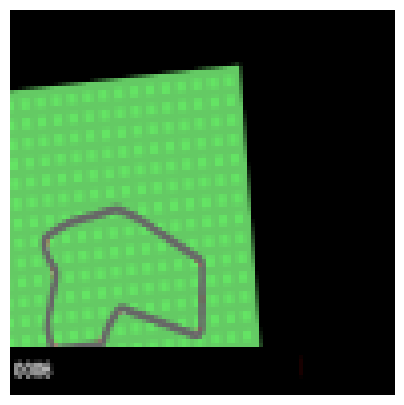

In [9]:

from IPython.display import HTML

frames = []
s, _ = env.reset()

while True:
    a = env.action_space.sample()
    s, r, terminated, truncated, _ = env.step(a)
    frames.append(s)
    if terminated or truncated:
        break


anim = animate(frames)
HTML(anim.to_jshtml())

So a couple things we can note:
- at the beginning of the game, we have 50 frames of the game slowly zooming into the car, we should ignore this period, ie no-op during this period.
- there is a black bar at the bottom of the screen, we should crop this out of the observation.

In addition, another thing to note is that the current frame doesn't give much information about the velocity and acceleration of the car, and that the car does not move much for each frame.
### Environment Wrapper (5 points)
As a result, you will need to complete `EnvWrapper` in `env_wrapper.py`. You can find more information in the docstring for the wrapper, however the main idea is that it is a wrapper to the environment that does the following:
- skips the first 50 frames of the game
- crops out the black bar and reshapes the observation to a 84x84 image, as well as turning the resulting image to grayscale
- performs the actions for `skip_frames` frames
- stacks the last `num_frames` frames together to give the agent some information about the velocity and acceleration of the car.


In [10]:
from env_wrapper import EnvWrapper

rl_test.test_wrapper(EnvWrapper)
# test.test_wrapper(EnvWrapper) #old

hi
Passed reset
Passed step


### CNN Model (5 points)
Now we are ready to build the model. Our architecture of the CNN model is the one proposed by Mnih et al in "Human-level control through deep reinforcement learning". Specifically this consists of the following layers:
- A convolutional layer with 32 filters of size 8x8 with stride 4 and relu activation
- A convolutional layer with 64 filters of size 4x4 with stride 2 and relu activation
- A convolutional layer with 64 filters of size 3x3 with stride 1 and relu activation
- A fully connected layer with 512 units and relu activation
- A fully connected layer with the number of outputs of the environment

Please implement this model `Nature_Paper_Conv` in `model.py` as well as the helper
`MLP` class.

In [11]:
import model

rl_test.test_model_DQN(model.Nature_Paper_Conv)
# test.test_model_DQN(model.Nature_Paper_Conv)old

Passed


### DQN (40 points)
Now we are ready to implement the DQN algorithm.

![title](DQN.png)

#### Replay Buffer (5 points)
First start by implementing the DQN replay buffer `ReplayBufferDQN` in `buffer.py`. This buffer will store the transitions of the agent and sample them for training.

In [12]:
from replay_buffer import ReplayBufferDQN

rl_test.test_DQN_replay_buffer(ReplayBufferDQN)

Passed



#### DQN (15 points)
Now implement the `_optimize_model` and `sample_action` functions in `DQN` in `DQN.py`. The `_optimize_model` function will sample a batch of transitions from the replay buffer and update the model. The `sample_action` function will sample an action from the model given the current state. Train the model over 200 episdoes, validating every 50 episodes for 30 episodes, before testing the model for 50 episodes at the end.

In [14]:
import DQN
import utils
import torch


trainerDQN = DQN.DQN(EnvWrapper(env),
                model.Nature_Paper_Conv,
                lr = 0.00025,
                gamma = 0.99,
                buffer_size=100000,
                batch_size=32,
                loss_fn = "mse_loss",
                use_wandb = False,
                device = 'cpu',
                seed = 42,
                epsilon_scheduler = utils.exponential_decay(1, 1000,0.1),
                save_path = utils.get_save_path("DQN","./runs/"))

trainerDQN.train(200,50,30,50,50)



saving to ./runs/DQN/run5


Please include a plot of the training and validation rewards over the episodes in the report. An additional question to answer is does the loss matter in DQN? Why or why not?

We can also draw a animation of the car in one game, the code is provided below

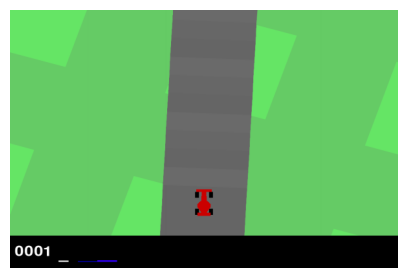

In [15]:
eval_env = gym.make('CarRacing-v2', continuous=True, render_mode='rgb_array')
eval_env = EnvWrapper(eval_env)

total_rewards, frames = trainerDQN.play_episode(0,True,42)
anim = animate(frames)
HTML(anim.to_jshtml())

### Double DQN
In the original paper, where the algorithim is shown above, the estimated target Q value was computed using the current Q network's weights. However, this can lead to overestimation of the Q values. To mitigate this, we can use the target network to compute the target Q value. This is known as Double DQN.
#### Hard updating Target Network (5 points)
Original implementations for this involved hard updates, where the model weights were copied to the target network every C steps. This is known as hard updating. This was what was used in the Nature Paper by Mnih et al 2015 "Human-level control through deep reinforcement learning"

Please implement this by implementing the `_optimize_model` and `_update_model` classes in `HardUpdateDQN` in `DQN.py`.


In [16]:
trainerHardUpdateDQN = DQN.HardUpdateDQN(EnvWrapper(env),
                model.Nature_Paper_Conv,
                update_freq = 100,
                lr = 0.00025,
                gamma = 0.99,
                buffer_size=100000,
                batch_size=32,
                loss_fn = "mse_loss",
                use_wandb = False,
                device = 'cuda',
                seed = 42,
                epsilon_scheduler = utils.exponential_decay(1, 1000,0.1),
                save_path = utils.get_save_path("DoubleDQN_HardUpdates/","./runs/"))

trainerHardUpdateDQN.train(200,50,30,50,50)

saving to ./runs/DoubleDQN_HardUpdates/run0


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
total_rewards, frames = trainerHardUpdateDQN.play_episode(0,True,42)
anim = animate(frames)
HTML(anim.to_jshtml())

#### Soft Updates (5 points)
A more recent improvement is to use soft updates, also known as Polyak averaging, where the target network is updated with a small fraction of the current model weights every step. In other words:
$$\theta_{target} = \tau \theta_{model} + (1-\tau) \theta_{target}$$
for some $\tau << 1$
Please implement this by implementing the `_update_model` class in `SoftUpdateDQN` in `DQN.py`.

In [ ]:
traineSoftUpdateDQN = DQN.SoftUpdateDQN(EnvWrapper(env),
                model.Nature_Paper_Conv,
                tau = 0.01,
                update_freq = 1,
                lr = 0.00025,
                gamma = 0.99,
                buffer_size=100000,
                batch_size=32,
                loss_fn = "mse_loss",
                use_wandb = False,
                device = 'cuda',
                seed = 42,
                epsilon_scheduler = utils.exponential_decay(1, 1000,0.1),
                save_path = utils.get_save_path("DoubleDQN_SoftUpdates","./runs/"))

traineSoftUpdateDQN.train(200,50,30,50,50)

FileNotFoundError: [Errno 2] No such file or directory: './runs/DoubleDQN_SoftUpdates'

In [ ]:
total_rewards, frames = traineSoftUpdateDQN.play_episode(0,True,42)
anim = animate(frames)
HTML(anim.to_jshtml())

#### Questions:
- Which method performed better? (5 points)
- If we modify the $\tau$ for soft updates or the $C$ for the hard updates, how does this affect the performance of the model, come up with a intuition for this, then experimentally verify this.
 (5 points)
